## Загрузка библиотек

In [524]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# обработка данных
import re
import string
import demoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
# модели
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
# улучшение модели
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from yellowbrick.model_selection import LearningCurve
# метрики качества модели
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve

# Загрузка и описание датасета

In [387]:
data = pd.read_csv('cyberbullying_tweets.csv')
display(data.shape)
data.head()

(47692, 2)

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


Датасет содержит 2 столбца и 47692 строки.

**Столбцы:**

- tweet_text: текст поста пользователя социальной сети Twitter

- cyberbullying_type: класс, к которому относится кибербуллинг в посте

In [523]:
list(data['cyberbullying_type'].unique())

['not_cyberbullying',
 'gender',
 'religion',
 'other_cyberbullying',
 'age',
 'ethnicity']

Тип кибербуллинга - качество, на основе которого осуществляется дискриминация.

**В датасет включены следующие типы:**

**Классы:**

- religion (религия)

- age (возраст)

- gender (пол)

- ethnicity (этническая принадлежность)

- not_cyberbullying (кибербуллинга нет)

- other_cyberbullying (другой тип кибербуллинга)

**Решаемая задача:**

По содержанию твитов (постов социальной сети Twitter) определить какой тип кибербуллинга содержится в нем. Данная задача в машинном обучении относится к задачам классификации.

# Предварительный анализ данных

In [331]:
data.isnull().sum() 

tweet_text            0
cyberbullying_type    0
dtype: int64

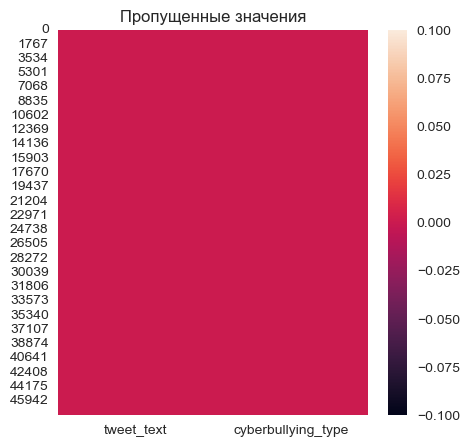

In [521]:
fig, ax = plt.subplots(figsize = (5, 5))
sns.heatmap(data.isnull())
ax.set(title = 'Пропущенные значения')
plt.show()

В датасете нет пропущенных значений.

In [510]:
data['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

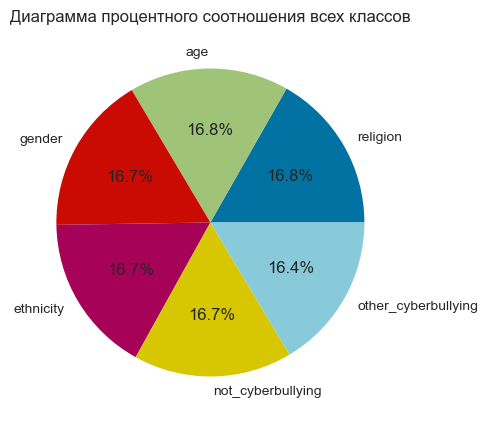

In [519]:
fig, ax = plt.subplots(figsize = (5, 5))
ax.pie(list(data['cyberbullying_type'].value_counts()), 
       labels=data['cyberbullying_type'].value_counts().index, 
       autopct='%1.1f%%'       )
ax.set(title = 'Диаграмма процентного соотношения всех классов')
plt.show()

Диcбаланса классов нет.

**Основная статистическая информация:**

In [333]:
data.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


In [334]:
data.info() #название столбца, количество ненулевых значений, тип данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


В обоих столбцах содержатся строковые данные.

## Разделение переменных

Разделим данные на признаки X и целевую переменную y.

In [401]:
X = data[['tweet_text']]
X.head()

,tweet_text
0,"In other words #katandandre, your food was cra..."
1,Why is #aussietv so white? #MKR #theblock #ImA...
2,@XochitlSuckkks a classy whore? Or more red ve...
3,"@Jason_Gio meh. :P thanks for the heads up, b..."
4,@RudhoeEnglish This is an ISIS account pretend...


In [390]:
y = data[['cyberbullying_type']]
y.head()

,cyberbullying_type
0,not_cyberbullying
1,not_cyberbullying
2,not_cyberbullying
3,not_cyberbullying
4,not_cyberbullying


# Обработка естественного языка

## Приведение к единому регистру

In [391]:
def make_lower(text):
    return text.str.lower()

## Удаление emoji

In [392]:
def remove_emoji(text):
    return pd.Series([demoji.replace(text_i, '') for text_i in text])

## Удаление знаков пунктуации

К знакам пунктуации относятся: '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [393]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [394]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

1. string.punctuation - это модуль Python string, который содержит все знаки пунктуации (такие как точки, запятые, вопросительные знаки и т. д.);

2. str.maketrans('', '', string.punctuation) - функция maketrans() создает таблицу перевода символов для использования с методом translate(). В данном случае, мы создаем таблицу перевода, которая указывает на то, что все знаки пунктуации должны быть заменены на пустую строку;

3. translate() - используется для применения таблицы перевода к тексту. В данном случае, он удаляет все знаки пунктуации из переменной text, используя созданную ранее таблицу перевода.

## Удаление ссылок

In [395]:
def remove_url(text):   
    return re.compile('https?://\S+|www\.\S+').sub('', text)

1. Функция re.compile создает регулярное выражение, которое будет искать текстовые строки, содержащие URL-адреса;

2. https?://\S+ - ищет строки, начинающиеся с "http://" или "https://", за которыми следует один или более символов, отличных от пробела;

3. www\.\S+ - ищет строки, начинающиеся с "www.", за которыми также следует один или более символов, отличных от пробела.

## Удаление стоп-слов

Стоп-слова представляют собой распространенные слова в языке, которые часто не несут глубокого смысла. Избавление от них помогает уменьшить объем текста для анализа и сфокусироваться на более важных словах, что улучшает точность и эффективность обработки текста.

К стоп-словам относятся местоимения (например: i, me, my, myself), артикли (a, an, the), предлоги (in, out, on, off) и т.д.

In [396]:
def remove_stopwords(text):
    sw = stopwords.words('english')
    filtered_text = []
    for word in text.split():
        if word not in sw:
            filtered_text.append(word)
    return ' '.join(filtered_text)

## Лемматизация

Лемматизация представляет собой процесс приведения слова к его нормальной, или словарной, форме, которая называется леммой.

In [397]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in text.split():
        lemma = lemmatizer.lemmatize(word)
        lemmas.append(lemma) 
    return ' '.join(lemmas)

Теперь применим все функции к X.

In [402]:
def text_preprocessing(X):
    X = make_lower(X)
    X = remove_emoji(X)
    X = X.apply(remove_punctuation)
    X = X.apply(remove_url)
    X = X.apply(remove_stopwords)
    X = X.apply(lemmatize_text)
    return X

X_pp = text_preprocessing(X['tweet_text'])

In [404]:
X = pd.DataFrame(X_pp, columns = ['tweet_text'])
X.head()

,tweet_text
0,word katandandre food crapilicious mkr
1,aussietv white mkr theblock imacelebrityau tod...
2,xochitlsuckkks classy whore red velvet cupcake
3,jasongio meh p thanks head concerned another a...
4,rudhoeenglish isi account pretending kurdish a...


Также необходимо привести целевую переменную к категориальному типу:

In [370]:
y = y.astype('category')
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   cyberbullying_type  47692 non-null  category
dtypes: category(1)
memory usage: 46.9 KB


## Деление выборки

In [405]:
y.value_counts()

cyberbullying_type 
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

Разделим выборку случайным образом в соотношении 80%/20%, где 80% строк выделяется для тренировочной выборки, а 20% - для тестовой.

В данном случае хорошо подходит именно случайное разделение, потому что данные достаточно однородны, нет дисбаланса классов и отсутствует временная структура.

In [429]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 52)

# Векторизация

Векторизация – преобразование входных данных из их исходного формата в векторы действительных чисел, которые понятны моделям машинного обучения. 

### TfidfVectorizer

Term Frequency-Inverse Document Frequency (TF-IDF) — это один из наиболее распространенных методов векторизации текстовых данных. Данный метод помогает найти ключевые слова и определить, какие слова имеют наибольшую значимость для текста в контексте всего набора текстов.

TF (Term Frequency) - частота термина, которая обозначает, насколько часто определенное слово появляется в данном тексте. 

IDF (Inverse Document Frequency) - обратная частота документа, которая измеряет, насколько уникальным слово является во всем наборе текстов. 

**Формула вычисления TF-IDF**

$$ TF-IDF(t, d) = TF(t, d) \cdot IDF(t), $$

где 

- $TF(t, d)$ - частота термина для слова t в тексте d; 

- $IDF(t)$ - обратная частота документа для слова t.

В дальнейшем буду применять векторизацию с помощью Pipeline.

## Метрики

Для оценки качества модели классификации применяют следующие метрики:

1. Матрица ошибок (Сonfusion matrix) - матрица, которая отображает количество правильно и неправильно распознанных объектов каждого класса. Дает наглядно понять, как хорошо работает модель.

2. Меткость (Accuracy) - доля правильно предсказанных классов. Характеризует качество модели, но зачастую используется в сочетании с другими метриками. Данная метрика часто используется в задачах классификации, когда все классы равноправны и одинаково важны, и нет явного дисбаланса классов.

3. Точность (Precision) -это метрика оценки качества модели в задачах классификации, которая измеряет долю правильно предсказанных положительных классов относительно всех объектов, которые модель предсказала как положительные. Эта метрика особенно полезна в случаях, когда наблюдается дисбаланс в количестве объектов различных классов.

4. Полнота (Recall) -  это отношение количества правильно определенных положительных объектов к общему числу действительно положительных объектов. Наиболее часто используеься когда присутствует дисбаланс классов.

5. F1-мера (F1-score) - взвешенное гармоническое среднее полноты и точности. 

6. Площадь под ROC-кривой (Area under ROC-curve, AUC-ROC) - это метрика оценивает баланс между частотой истинных и ложных положительных результатов при различных пороговых значениях классификации.

7. Площадь под кривой полнота-точность (Area under precision-recall curve, AUC-PR) - это метрика предоставляет всестороннюю оценку работы модели на различных уровнях точности и полноты при различных порогах классификации. Используется, когда необходимо оценить эффективность модели классификации при различных компромиссах между precision и recall и выбрать оптимальное значение порога. Он особенно полезен, когда есть дисбаланс классов.

Так как в датасете отсутствует дисбаланс классов, а также нет четкого приоритета классов, наиболее подходящей метрикой для оценки качества модели будет меткость (accuracy). На ее основе будет проводиться выбор модели. Остальные метрики будут вспомогательными, для более точного определения эффективности модели.

# Выбор модели

Проведу сравнение нескольких моделей с помощь кросс-валидировации. Для сравнения буду использовать следующие модели: 

1. модель логистической регрессии (LogisticRegression); 

2. метод опорных векторов без ядра (SVC(kernel = "linear")); 

3. метод опорных векторов с гауссовским ядром (SVC(kernel = "rbf")); 

4. мультиномиальная модель Наивного Байеса (MultinomialNB); 

5. градиентный бустинг (GradientBoostingClassifier); 

6. случайный лес (RandomForestClassifier);

7. стохастический градиентный спуск (SGDClassifier).

In [430]:
classifiers = {"Logistic Regression": LogisticRegression(max_iter = 1000),
               "Linear SVM": SVC(kernel = "linear"),
               "RBF SVM": SVC(kernel = "rbf"),
               "Multinomial Naive Bayes": MultinomialNB(),
               "Gradient Boosting": GradientBoostingClassifier(),
               "Random Forest": RandomForestClassifier(),
               "SGD": SGDClassifier()}

In [431]:
X_train_1 = X_train['tweet_text'].to_numpy()
y_train_1 = y_train['cyberbullying_type'].to_numpy()

In [423]:
scores = {}
for name, clf in classifiers.items():
    model = Pipeline([('tfidf', TfidfVectorizer()), (name, clf)])
    cv_results = cross_val_score(model, X_train_1, y_train_1, cv = 5, scoring = 'accuracy')
    scores[name] = [cv_results.mean(), cv_results.std()]

In [434]:
scores = {}
for name, clf in classifiers.items():
    model = Pipeline([('tfidf', TfidfVectorizer()), (name, clf)])
    cv_results = cross_validate(model, 
                                X_train_1, y_train_1, 
                                cv = 5, 
                                scoring = 'accuracy',
                                return_train_score = True)
    scores[name] = [cv_results['test_score'].mean(), 
                    cv_results['train_score'].mean(), 
                    cv_results['fit_time'].mean()]

In [435]:
df = pd.DataFrame(scores, index = ['test_score', 'train_score', 'fit_time']).T
df.sort_values(by = ['test_score'], ascending = False, inplace = True)
df

,test_score,train_score,fit_time
Linear SVM,0.834430,0.939212,41.245258
SGD,0.829135,0.907838,0.524521
Gradient Boosting,0.828768,0.844226,116.391740
RBF SVM,0.824627,0.962146,84.603885
Logistic Regression,0.824444,0.917746,9.038022
Random Forest,0.823002,0.976863,269.065070
Multinomial Naive Bayes,0.752418,0.863510,0.449740


По результатам обучения всех моделей, лучший результат показали модели метода опорных векторов без ядра, стохастический градиентный спуск и градиентный бустинг. Проведем более подробный анализ каждой из этих моделей и выберем лучшую.

## Linear SVM

**Кривая обучения**

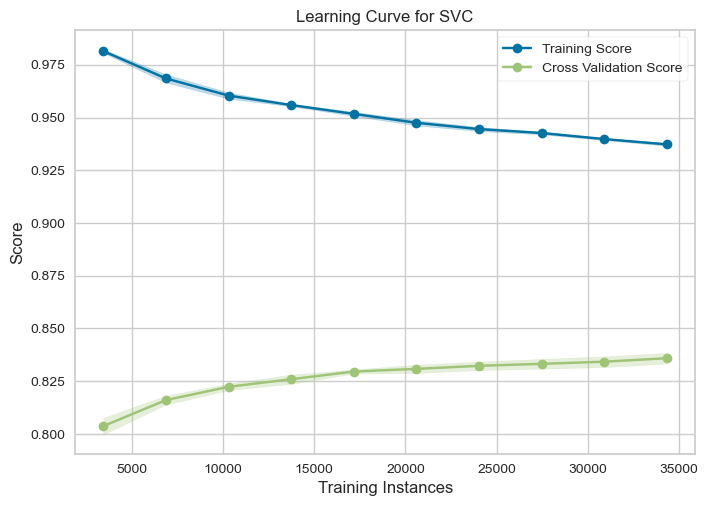

In [428]:
model = Pipeline([('tfidf', TfidfVectorizer()), ('svc', SVC(kernel = "linear"))])
visualizer = LearningCurve(
    model, train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X_train_1, y_train_1).show() 

По графику кривой обучения можно увидеть, что модель немного переобучена.

**Подбор гиперпараметров**

In [447]:
params_svc = {'svc__C': [0.01, 0.1, 1, 10, 100, 1000]}
model_svc = Pipeline([('tfidf', TfidfVectorizer()), ('svc', SVC(kernel = "linear"))])
grid_model_svc = GridSearchCV(estimator = model_svc,
                          param_grid = params_svc,
                          scoring = 'accuracy',
                          cv = 3,
                          return_train_score = True)
grid_model_svc.fit(X_train_1, y_train_1)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svc', SVC(kernel='linear'))]),
             param_grid={'svc__C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='accuracy')

In [449]:
cv_info = pd.DataFrame(grid_model_svc.cv_results_)[['param_svc__C', 
                                                    'mean_test_score', 
                                                    'mean_train_score', 
                                                    'rank_test_score']]
cv_info.sort_values(by = ['rank_test_score'], ascending = True, inplace = True)
cv_info

,param_svc__C,mean_test_score,mean_train_score,rank_test_score
2,1,0.832910,0.943320,1
3,10,0.810107,0.978494,2
1,0.1,0.800016,0.810395,3
4,100,0.798967,0.980552,4
5,1000,0.795927,0.980644,5
0,0.01,0.635808,0.619768,6


Получили, что наилучшей моделью будет: SVC(C = 1, kernel = "linear"). Гиперпараметр C, который подбирался, является параметром по умолчанию, следовательно, кривая обучения, построенная выше, соответствует лучшей модели.

**Метрики**

In [443]:
X_test_1 = X_test['tweet_text'].to_numpy()
y_test_1 = y_test['cyberbullying_type'].to_numpy()

In [451]:
best_model_svc = grid_model_svc.best_estimator_
best_model_svc.fit(X_train_1, y_train_1)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('svc', SVC(C=1, kernel='linear'))])

In [455]:
y_pred = best_model_svc.predict(X_test_1)

acc_svc = accuracy_score(y_test_1, y_pred)
pr_svc = precision_score(y_test_1, y_pred, average = 'macro')
rc_svc = recall_score(y_test_1, y_pred, average = 'macro')
f1_svc = f1_score(y_test_1, y_pred, average = 'macro')

metrics_svc = pd.DataFrame({'Linear SVM': [acc_svc, pr_svc, rc_svc, f1_svc]}, 
                           index = ['Accuracy', 'Precision', 'Recall', 'F1'])
metrics_svc

,Linear SVM
Accuracy,0.836985
Precision,0.836441
Recall,0.837544
F1,0.836265


Построим матрицу ошибок для лучшего понимания того, какие классы модель предсказывает правильно:

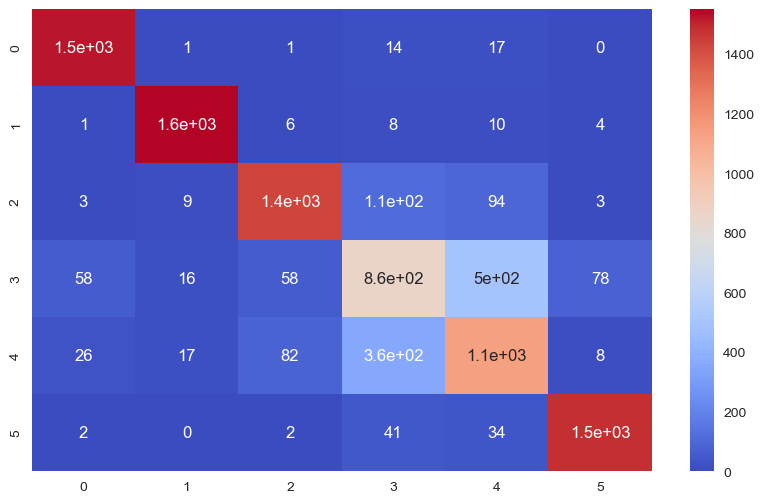

In [480]:
plt.figure(figsize = (10,6))
sns.heatmap(confusion_matrix(y_test_1, y_pred), cmap="coolwarm", annot = True)
plt.show()

По матрице ошибок видим, что количество ошибок очень мало по отношению к всей выборке.

Проанализируем кривые ROC-AUC и PR-AUC:

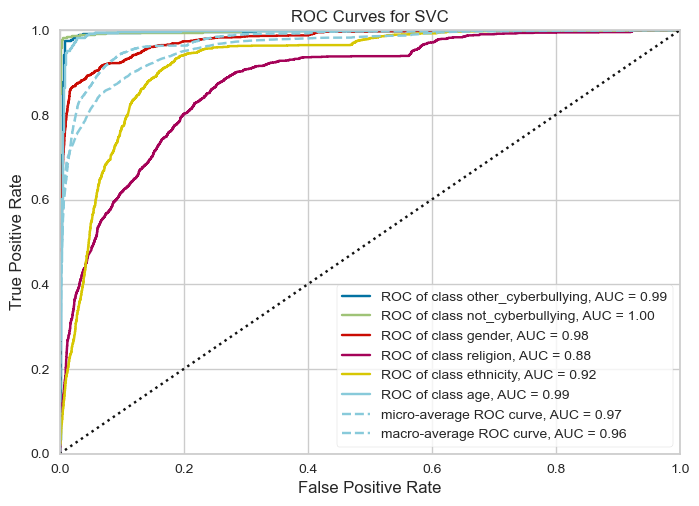

<Axes: title={'center': 'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [461]:
cls = pd.unique(y_train_1)
visualizer_roc = ROCAUC(best_model_svc, classes = cls)
visualizer_roc.fit(X_train_1, y_train_1)
visualizer_roc.score(X_test_1, y_test_1)
visualizer_roc.show()

На графике ROC кривых представленны кривые и метрики для каждого из шести классов. Так как данный показатель применим только к бинарной классификации, алгоритм рассчитывает метрики для каждого класса, обозначая нужный класс за 0, а остальные за 1, тем самым приводя к бинарной классификации.

Показатель AUC−ROC является мерой качества классификатора относительно идеального. Значение показателя в пределах [0.8, 1] говорит об очень хорошем качестве модели.



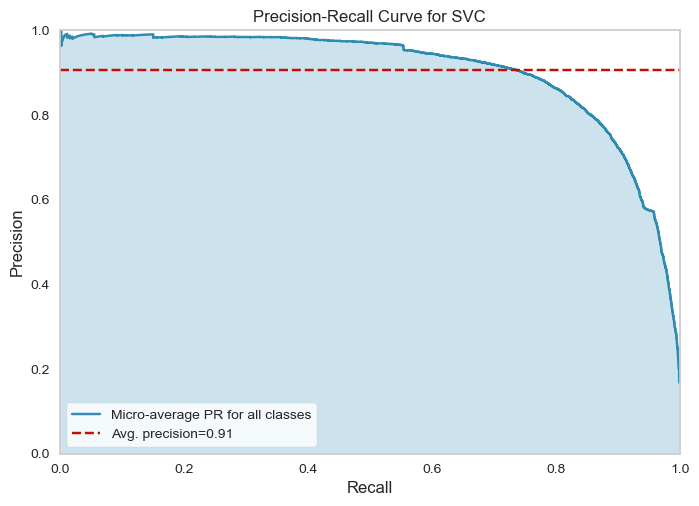

<Axes: title={'center': 'Precision-Recall Curve for SVC'}, xlabel='Recall', ylabel='Precision'>

In [462]:
visualizer_pr = PrecisionRecallCurve(best_model_svc, classes = cls)
visualizer_pr.fit(X_train_1, y_train_1)
visualizer_pr.score(X_test_1, y_test_1)
visualizer_pr.show()

PR-AUC - метрика, отражает качество классификатора и позволяет сравнивать кривые, соответствующие различным балансам классов и значениям порога. Чем выше площадь, тем лучше работает модель. В данном случае метрика равна 0.91, что говорит о хорошем качестве модели.

## SGD

**Кривая обучения**

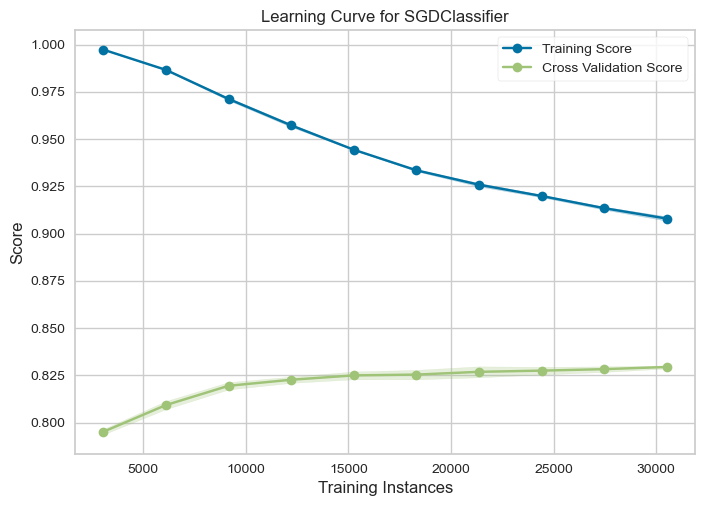

In [526]:
model_sgd = Pipeline([('tfidf', TfidfVectorizer()), ('sgd', SGDClassifier())])
visualizer = LearningCurve(
    model_sgd, train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X_train_1, y_train_1).show() 

По кривой обучения можно сделать выво, что модель немного недообучена.

**Подбор гиперпараметров**

In [528]:
params_sgd = {'sgd__penalty': ['l2', 'l1', 'elasticnet', None],
              'sgd__alpha': [0.0001, 0.01, 1, 10, 100]}
model_sgd = Pipeline([('tfidf', TfidfVectorizer()), ('sgd', SGDClassifier())])
grid_model_sgd = GridSearchCV(estimator = model_sgd,
                          param_grid = params_sgd,
                          scoring = 'accuracy',
                          cv = 3,
                          return_train_score = True)
grid_model_sgd.fit(X_train_1, y_train_1)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('sgd', SGDClassifier())]),
             param_grid={'sgd__alpha': [0.0001, 0.01, 1, 10, 100],
                         'sgd__penalty': ['l2', 'l1', 'elasticnet', None]},
             return_train_score=True, scoring='accuracy')

In [531]:
cv_info_2 = pd.DataFrame(grid_model_sgd.cv_results_)[['param_sgd__alpha',
                                                      'param_sgd__penalty', 
                                                      'mean_test_score', 
                                                      'mean_train_score', 
                                                      'rank_test_score']]
cv_info_2.sort_values(by = ['rank_test_score'], ascending = True, inplace = True)
cv_info_2

,param_sgd__alpha,param_sgd__penalty,mean_test_score,mean_train_score,rank_test_score
0,0.0001,l2,0.827510,0.916520,1
2,0.0001,elasticnet,0.826881,0.877074,2
1,0.0001,l1,0.821928,0.828978,3
3,0.0001,None,0.816581,0.954617,4
7,0.01,None,0.776426,0.805350,5
4,0.01,l2,0.749535,0.808062,6
6,0.01,elasticnet,0.678321,0.677470,7
11,1,None,0.599350,0.598839,8
5,0.01,l1,0.569419,0.569653,9
15,10,None,0.364953,0.355214,10


В результате подбора гиперпараметров получили лучшую модель: SGDClassifier(penalty = 'l2', alpha = 0.0001).

**Метрики**

In [443]:
X_test_1 = X_test['tweet_text'].to_numpy()
y_test_1 = y_test['cyberbullying_type'].to_numpy()

In [532]:
best_model_sgd = grid_model_sgd.best_estimator_
best_model_sgd.fit(X_train_1, y_train_1)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('sgd', SGDClassifier())])

In [535]:
y_pred_2 = best_model_sgd.predict(X_test_1)

acc_sgd = accuracy_score(y_test_1, y_pred_2)
pr_sgd = precision_score(y_test_1, y_pred_2, average = 'macro')
rc_sgd = recall_score(y_test_1, y_pred_2, average = 'macro')
f1_sgd = f1_score(y_test_1, y_pred_2, average = 'macro')

metrics_sgd = pd.DataFrame({'SGD': [acc_sgd, pr_sgd, rc_sgd, f1_sgd]}, 
                           index = ['Accuracy', 'Precision', 'Recall', 'F1'])
metrics_sgd

,SGD
Accuracy,0.831010
Precision,0.824691
Recall,0.831573
F1,0.824326


Построим матрицу ошибок для лучшего понимания того, какие классы модель предсказывает правильно:

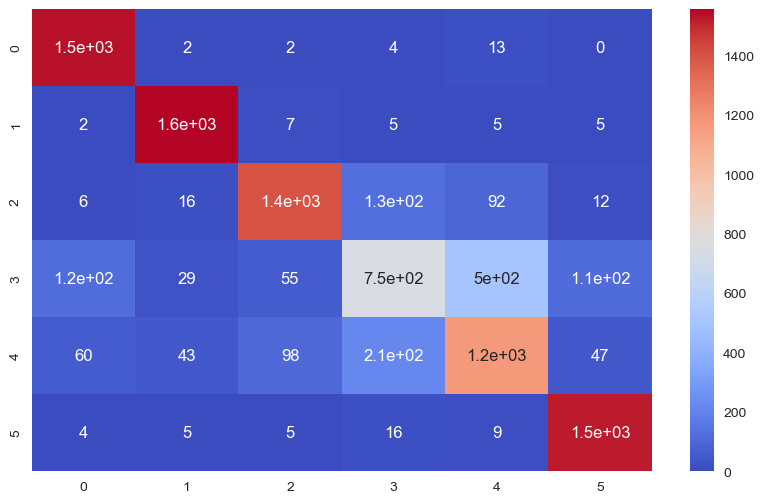

In [536]:
plt.figure(figsize = (10,6))
sns.heatmap(confusion_matrix(y_test_1, y_pred_2), cmap="coolwarm", annot = True)
plt.show()

По матрице ошибок видим, что количество ошибок очень мало по отношению к всей выборке.

Проанализируем кривые ROC-AUC и PR-AUC:

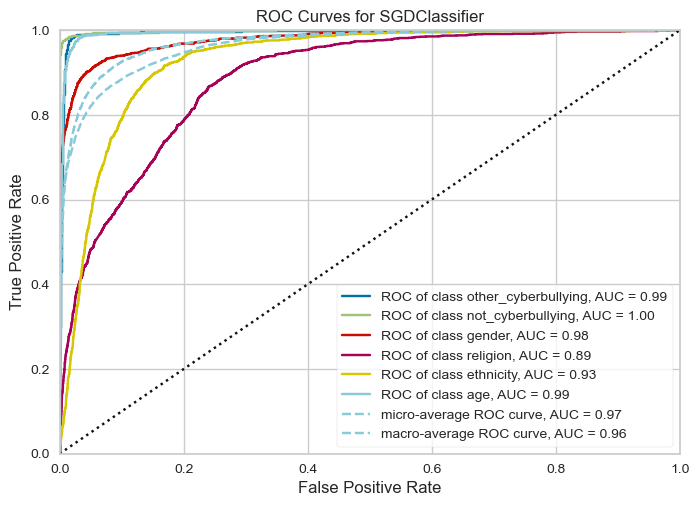

<Axes: title={'center': 'ROC Curves for SGDClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [537]:
cls = pd.unique(y_train_1)
visualizer_roc = ROCAUC(best_model_sgd, classes = cls)
visualizer_roc.fit(X_train_1, y_train_1)
visualizer_roc.score(X_test_1, y_test_1)
visualizer_roc.show()

Показатель AUC−ROC является мерой качества классификатора относительно идеального. Значение показателя в пределах [0.8, 1] говорит об очень хорошем качестве модели.



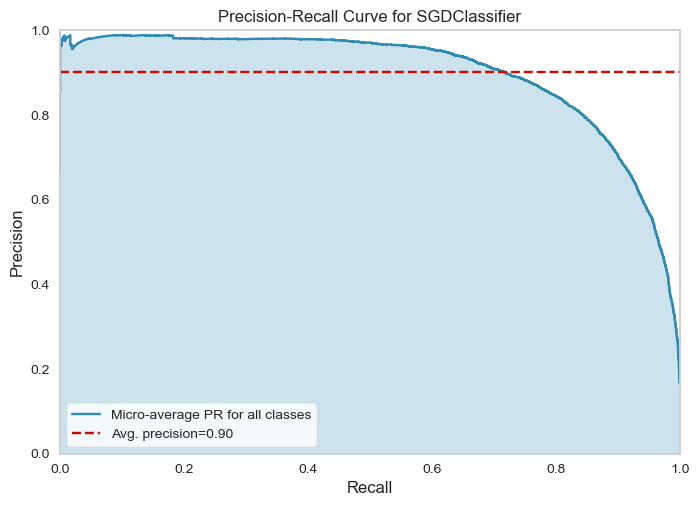

<Axes: title={'center': 'Precision-Recall Curve for SGDClassifier'}, xlabel='Recall', ylabel='Precision'>

In [538]:
visualizer_pr = PrecisionRecallCurve(best_model_sgd, classes = cls)
visualizer_pr.fit(X_train_1, y_train_1)
visualizer_pr.score(X_test_1, y_test_1)
visualizer_pr.show()

PR-AUC - метрика, отражает качество классификатора и позволяет сравнивать кривые, соответствующие различным балансам классов и значениям порога. Чем выше площадь, тем лучше работает модель. В данном случае метрика равна 0.9, что говорит о хорошем качестве модели.

## Gradient Boosting

**Кривая обучения**

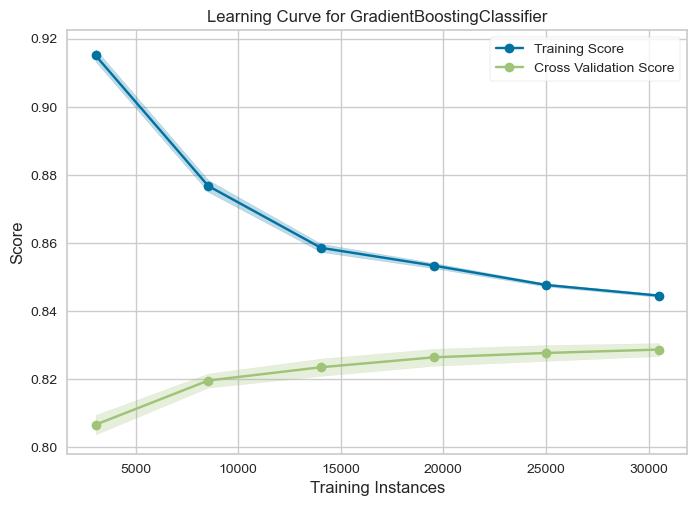

In [437]:
model = Pipeline([('tfidf', TfidfVectorizer()), ('gb', GradientBoostingClassifier())])
visualizer = LearningCurve(
    model, train_sizes=np.linspace(0.1, 1.0, 6)
).fit(X_train_1, y_train_1).show() 

**Подбор гиперпараметров**

In [464]:
params_gb = {'gb__learning_rate': [0.01, 0.1, 1.0],
             'gb__n_estimators' : [100, 500, 1000]}
model_gb = Pipeline([('tfidf', TfidfVectorizer()), ('gb', GradientBoostingClassifier())])
grid_model_gb = GridSearchCV(estimator = model_gb,
                             param_grid = params_gb,
                             scoring = 'accuracy',
                             cv = 2,
                             return_train_score = True)
grid_model_gb.fit(X_train_1, y_train_1)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('gb', GradientBoostingClassifier())]),
             param_grid={'gb__learning_rate': [0.01, 0.1, 1.0],
                         'gb__n_estimators': [100, 500, 1000]},
             return_train_score=True, scoring='accuracy')

In [471]:
cv_info_1 = pd.DataFrame(grid_model_gb.cv_results_)[['param_gb__learning_rate', 
                                                     'param_gb__n_estimators',
                                                     'mean_test_score',
                                                     'mean_train_score',
                                                     'rank_test_score']]
cv_info_1.sort_values(by = ['rank_test_score'], ascending = True, inplace = True)
cv_info_1

,param_gb__learning_rate,param_gb__n_estimators,mean_test_score,mean_train_score,rank_test_score
4,0.1,500,0.828637,0.910204,1
2,0.01,1000,0.826908,0.845753,2
3,0.1,100,0.826567,0.852174,3
5,0.1,1000,0.824601,0.967919,4
1,0.01,500,0.815218,0.824234,5
6,1.0,100,0.809609,0.843368,6
7,1.0,500,0.809085,0.843499,7
8,1.0,1000,0.808796,0.844862,8
0,0.01,100,0.784027,0.785521,9


Получили, что наилучшей моделью будет: GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 500).

**Метрики**

In [467]:
best_model_gb = grid_model_gb.best_estimator_
best_model_gb.fit(X_train_1, y_train_1)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('gb', GradientBoostingClassifier(n_estimators=500))])

In [468]:
y_pred_1 = best_model_gb.predict(X_test_1)

acc_gb = accuracy_score(y_test_1, y_pred_1)
pr_gb = precision_score(y_test_1, y_pred_1, average = 'macro')
rc_gb = recall_score(y_test_1, y_pred_1, average = 'macro')
f1_gb = f1_score(y_test_1, y_pred_1, average = 'macro')

metrics_gb = pd.DataFrame({'Gradient Boosting': [acc_gb, pr_gb, rc_gb, f1_gb]}, 
                           index = ['Accuracy', 'Precision', 'Recall', 'F1'])
metrics_gb

,Gradient Boosting
Accuracy,0.838348
Precision,0.851120
Recall,0.838411
F1,0.838484


Построим матрицу ошибок для лучшего понимания того, какие классы модель предсказывает правильно:

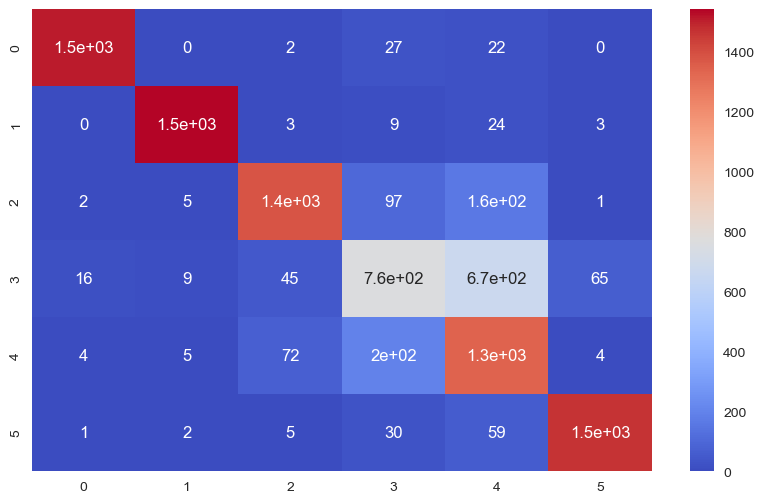

In [482]:
plt.figure(figsize = (10,6))
sns.heatmap(confusion_matrix(y_test_1, y_pred_1), cmap="coolwarm", annot = True)
plt.show()

По матрице ошибок видим, что количество ошибок очень мало по отношению к всей выборке.

Проанализируем кривые ROC-AUC и PR-AUC:

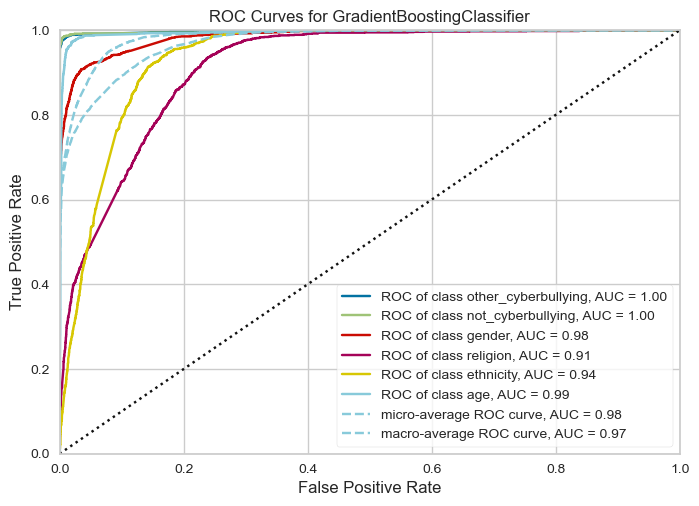

<Axes: title={'center': 'ROC Curves for GradientBoostingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [469]:
cls = pd.unique(y_train_1)
visualizer_roc_1 = ROCAUC(best_model_gb, classes = cls)
visualizer_roc_1.fit(X_train_1, y_train_1)
visualizer_roc_1.score(X_test_1, y_test_1)
visualizer_roc_1.show()

Значение показателя в пределах [0.9, 1] говорит об отличном качестве модели.

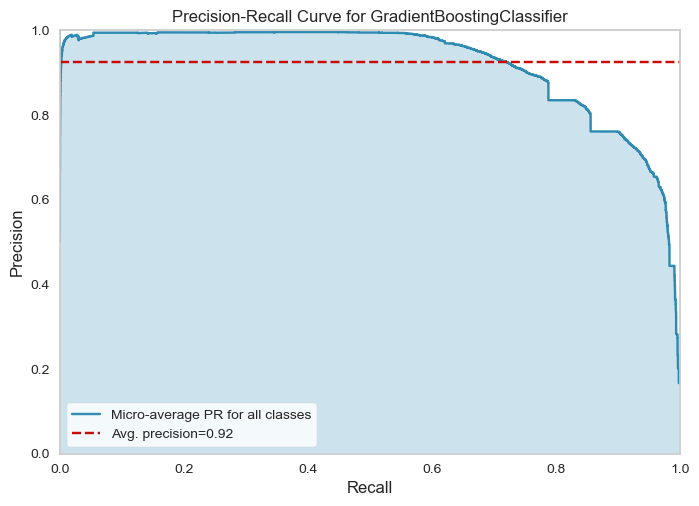

<Axes: title={'center': 'Precision-Recall Curve for GradientBoostingClassifier'}, xlabel='Recall', ylabel='Precision'>

In [470]:
visualizer_pr_1 = PrecisionRecallCurve(best_model_gb, classes = cls)
visualizer_pr_1.fit(X_train_1, y_train_1)
visualizer_pr_1.score(X_test_1, y_test_1)
visualizer_pr_1.show()

Метрика PR-AUC равна 0.92, что говорит о хорошем качестве модели.

## Промежуточный вывод

После проведения полного анализа всех трех моделей, а также подбора их гиперпараметров, получили, что они все дают приблизительно одинаковый результат на тестовой выборке. Следовательно, выбор модели стоит делать на основе ее сложности. В данном случае более "простой" моделью является метод опорных векторов.

# Прогноз

## Обучение модели на всей выборке

Для еще большего повышения точности модели, обучим ее на всей выборке.

In [483]:
X_1 = X['tweet_text'].to_numpy()
y_1 = y['cyberbullying_type'].to_numpy()

best_model_svc = grid_model_svc.best_estimator_
best_model_svc.fit(X_1, y_1)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('svc', SVC(C=1, kernel='linear'))])

## Создание новых тестов

In [503]:
test_1 = pd.DataFrame(['You look so amazing today 😍😍😍😍😍 i dont believe u exist', 
                       'i dont understand why you like this color so much ?? only stupid people like it'], 
                      columns = ['test'])
test_1

,test
0,You look so amazing today 😍😍😍😍😍 i dont believe...
1,i dont understand why you like this color so m...


Данные тесты предпологают отношение к классам 'not_cyberbullying' и 'other_cyberbullying' соответственно.

Проведем предобработку теста:

In [504]:
test_1 = text_preprocessing(test_1['test']).to_numpy()
test_1

array(['look amazing today dont believe u exist',
       'dont understand like color much stupid people like'], dtype=object)

Сделаем прогноз:

In [505]:
best_model_svc.predict(test_1)

array(['not_cyberbullying', 'other_cyberbullying'], dtype=object)

Можно увидеть, что модель правильно предсказала оба класса, что говорит о её работоспособности.

# Вывод

Машинное обучение играет ключевую роль в решении задач обработки текста на естественных языках, включая выявление кибербуллинга в социальных медиа. Модель, разработанная в данной работе, позволяет определить наличие киббербуллинга, а также его тип. Такая модель может быть использована, например, при создании ботов, которые бы автоматически удаляли агрессивные комментарии.

Таким образом, можно сказать, что исследование, проведенное в данной работе, имеет большой потенциал и может быть использовано на благо общества.
